In [1]:
import os
from pydlv import data_reader, derivative_calculator

dr = data_reader.DataReader()
dc = derivative_calculator.DerivativeCalculator()

data = dr.read_data(path='../../../data')
# rewards_sum defines the experimental conditions to be analysed (see data description on OSF for details)
# reward sums of 12, 15 and 25 correspond to the High vs. Low condition in 7/5, 10/5 and 20/5 experiments, respectively
data = dr.preprocess_data(data, rewards_sum = [12, 15, 25])
data = dc.append_derivatives(data)

Cache the processed data to csv so that you don't need to preprocess the raw data every time you analyse it.

In [2]:
if not os.path.exists('csv'):
    os.makedirs('csv')
data.to_csv('csv/processed_data_high_low.csv')

Next time just read the already processed data:

In [3]:
import pandas as pd
data = pd.read_csv('csv/processed_data_high_low.csv', sep=',', header=0)
data.set_index(['subj_id', 'trial_no'], inplace=True, drop=True)

Before generating the decision landscapes, filter out trials with changes-of-mind or with too many x-flips, and exclude two subjects with problematic data.

In [4]:
data = data[(data.xflip_count < 4) & (data.chng_mind == False)]
data = data.drop([2302, 3217], level = 'subj_id')

Decision landscape time! Let's try the model with alpha=3 (that is, with four free parameters). We generate individual-level landscapes for all participants in the dataset.

In [5]:
from pydlv import dl_model_3, dl_generator

model = dl_model_3.DLModel3()
dlg = dl_generator.DLGenerator(model)

fit_dl = lambda trajs: dlg.fit_dl_mult_traj(trajs, method=9)    
fit_params = data.groupby(level='subj_id').apply(fit_dl)
fit_params.index = fit_params.index.droplevel(1)

fit_params.to_csv('csv/fit_params_by_subject.csv')

Now that we've got the parameters for every subject, we can compare the landscapes!

<IPython.core.display.Javascript object>


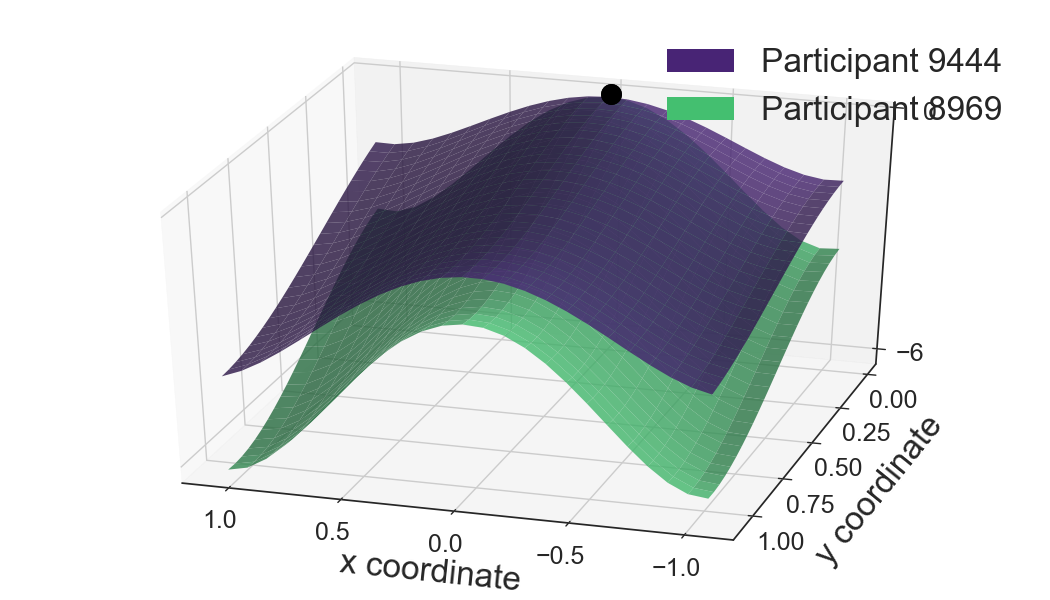

In [6]:
%matplotlib notebook

from pydlv import dl_plotter
from matplotlib import cm

dlp = dl_plotter.DLPlotter(elev=33, azim=107)

subjects = [9444, 8969]
labels = ['Participant %i' % (subj_id) for subj_id in subjects]
cmap = cm.viridis
colors = [cmap(0.1), cmap(0.7)]

for i, subj_id in enumerate(subjects):
    x, y, dl = dlg.get_model_dl(fit_params.loc[subj_id][2:2+model.n_params])
    dlp.plot_surface(x, y, dl, color=colors[i], alpha=0.8)

dlp.add_legend(colors, labels)